In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("./multiscale-ssh")))  # replace with real path

from DL_models import UNet  
from DL_models import CNN
from FCNN import FCNN
from loss_function import CombinedLoss
from train_test2 import train_model
from train_test import evaluate_model_sr
from visualization import plot_predictions_vs_targets, plot_predictions_vs_targets_sr
from visualization import plot_mean_power_spectrum, plot_mean_power_spectrum_sr
from visualization import plot_train_val_losses
from visualization import plot_mean_esr
from dataloading import prepare_dataloaders, prepare_dataloaders_multiVar
from qualitative_eval import mse, r2_score, pearson_corr, first_esr_exceeds_half

In [2]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
# import preprocessing
import os
import xrft
import gcm_filters
import random
import scipy
from scipy.ndimage import convolve

warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

/srv/conda/envs/notebook/lib/python3.12/site-packages/pop_tools/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [3]:
def r2_per_sample(y_true, y_pred):
    n_samples = y_true.shape[0]
    r2_scores = np.empty(n_samples)
    
    for i in range(n_samples):
        yt = y_true[i].reshape(-1)
        yp = y_pred[i].reshape(-1)
        ss_res = np.sum((yt - yp) ** 2)
        ss_tot = np.sum((yt - np.mean(yt)) ** 2)
        r2_scores[i] = 1 - ss_res / ss_tot
    
    return r2_scores

In [4]:
def reset_seeds(seed=42):
    import torch, numpy as np, random
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Data Pre-processing

In [5]:
#ds_HR_reg = xr.open_dataset("gs://leap-persistent/panalluri/ds_HR_globalRegions.zarr", engine="zarr", chunks={}) 
#ds_LR_reg = xr.open_dataset("gs://leap-persistent/panalluri/ds_LR_globalRegions.zarr", engine="zarr", chunks={}) 
#ds_HF_reg = xr.open_dataset("gs://leap-persistent/panalluri/ds_HF_globalRegions.zarr", engine="zarr", chunks={}) 

In [5]:
ds_HR = xr.open_dataset("gs://leap-persistent/panalluri/ds_HR.zarr", engine="zarr", chunks={}) 
ds_LR = xr.open_dataset("gs://leap-persistent/panalluri/ds_LR.zarr", engine="zarr", chunks={}) 
ds_HF = xr.open_dataset("gs://leap-persistent/panalluri/ds_HF.zarr", engine="zarr", chunks={}) 

# Select region of interest
ds_HR_reg = ds_HR.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))
ds_LR_reg = ds_LR.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))
ds_HF_reg = ds_HF.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))

In [6]:
# Config choices Abigail chose

input_channels = 6
output_channels = 1
conv_layers = 7
kernel = 5
#init_bound = 0.5
kernel_hidden = 3
activation = "ReLU"
arch = "fcnn"

config={"input_channels":input_channels,
        "output_channels":output_channels,
        "activation":activation,
        "arch":arch,
        "conv_layers":conv_layers,
        "kernel":kernel,
        "kernel_hidden":kernel_hidden}

# Case 1: No Normalization

In [7]:
reset_seeds(42)
model1 = FCNN(config=config)
model1

FCNN(
  (conv): Sequential(
    (0): Conv2d(6, 128, kernel_size=(5, 5), stride=(1, 1), padding=same, padding_mode=reflect)
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (7): ReLU()
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (10): ReLU()
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (13): ReLU()
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affi

In [8]:
var_LR = ['u_relative', 'v_relative', 't_ref', 'surface_temp', 'q_ref', 'slp']
train_loader, val_loader, test_loader, HF_test, LR_test = prepare_dataloaders_multiVar(ds_HF_reg, ds_LR_reg, var_LR=var_LR, var_HF='heatflux_diff', batch_size=32)

Training set size: 510
Validation set size: 109
Testing set size: 111


In [9]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3)
device = torch.device("cuda")

train_losses, val_losses, r2_vals = train_model(model1, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_noNorm_r2.pth',
            n_epochs=2000, patience=30, stop_crit='R2', lr_sched_crit='R2') # n_epochs=2000)

Trainable Parameters: 149569
Epoch 1, Train Loss: 4.539e+01, Val Loss: 3.974e+01, Val R²: -0.2935, Epoch Time: 12.56s
Model saved at epoch 1
Epoch 2, Train Loss: 4.074e+01, Val Loss: 1.417e+02, Val R²: -3.6492, Epoch Time: 12.10s
Model saved at epoch 2
Epoch 3, Train Loss: 3.920e+01, Val Loss: 1.288e+04, Val R²: -521.5326, Epoch Time: 12.26s
Model saved at epoch 3
Epoch 4, Train Loss: 3.781e+01, Val Loss: 2.556e+04, Val R²: -1033.6764, Epoch Time: 12.40s
Model saved at epoch 4
Epoch 5, Train Loss: 3.703e+01, Val Loss: 8.140e+03, Val R²: -336.3275, Epoch Time: 12.54s
Model saved at epoch 5
Epoch 6, Train Loss: 3.602e+01, Val Loss: 4.240e+03, Val R²: -164.7753, Epoch Time: 12.75s
Model saved at epoch 6
Epoch 7, Train Loss: 3.513e+01, Val Loss: 2.289e+04, Val R²: -917.5563, Epoch Time: 12.84s
Model saved at epoch 7
Epoch 8, Train Loss: 3.340e+01, Val Loss: 1.302e+06, Val R²: -52518.8516, Epoch Time: 13.08s
Model saved at epoch 8
Epoch 9, Train Loss: 3.152e+01, Val Loss: 2.695e+05, Val R²:

In [10]:
device = torch.device("cuda")
sgs_pred = evaluate_model_sr(model1, device, test_loader, HF_test, './model_noNorm_r2.pth')
sgs_pred

Loaded model parameters from ./model_noNorm_r2.pth


array([[[-1.4973292 , -1.497688  , -1.4979911 , ..., -1.4731033 ,
         -1.4732457 , -1.4737353 ],
        [-1.4948763 , -1.4952319 , -1.4955385 , ..., -1.472874  ,
         -1.4730117 , -1.473499  ],
        [-1.4930681 , -1.4934261 , -1.4937394 , ..., -1.4731072 ,
         -1.4732435 , -1.4737275 ],
        ...,
        [-2.381111  , -2.3839865 , -2.3860953 , ..., -1.8736795 ,
         -1.8767129 , -1.8816477 ],
        [-2.3789558 , -2.3818288 , -2.3839157 , ..., -1.8729337 ,
         -1.8760406 , -1.8810248 ],
        [-2.3743496 , -2.3772178 , -2.3792784 , ..., -1.8719007 ,
         -1.8750871 , -1.8801124 ]],

       [[-1.3945701 , -1.3938621 , -1.3935132 , ..., -1.358193  ,
         -1.3579323 , -1.3578179 ],
        [-1.3979628 , -1.3972627 , -1.3969134 , ..., -1.361782  ,
         -1.3615289 , -1.3614149 ],
        [-1.4017586 , -1.4010547 , -1.4006909 , ..., -1.3658712 ,
         -1.365616  , -1.3654974 ],
        ...,
        [-1.265402  , -1.2608862 , -1.2585826 , ..., -

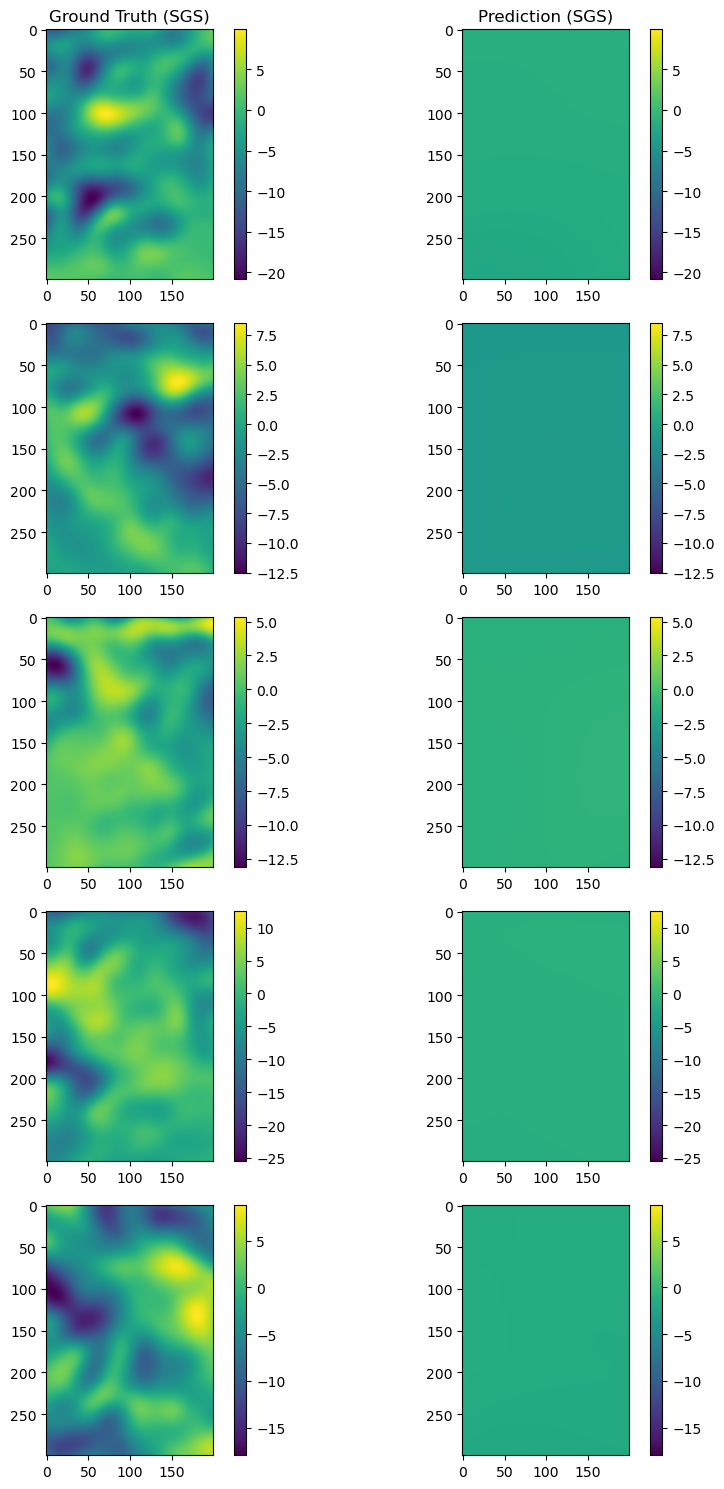

In [11]:
plot_predictions_vs_targets(HF_test, sgs_pred, num_samples=5, cmap='viridis', cbar_shared_lims=True)

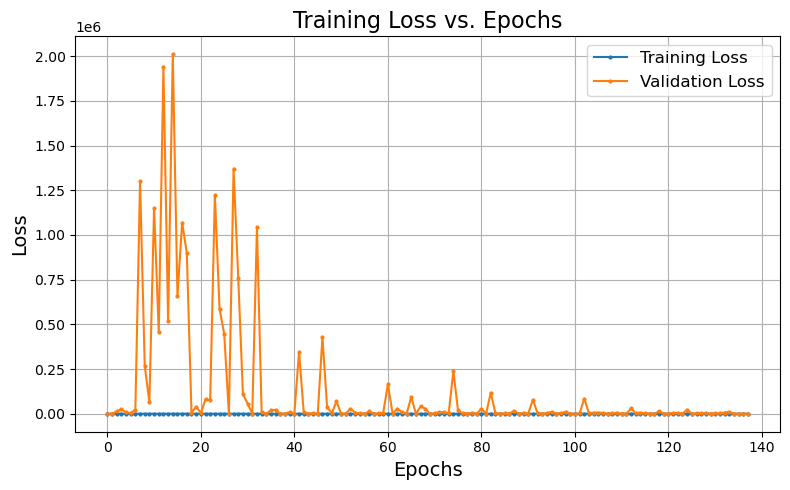

In [12]:
plot_train_val_losses(train_losses, val_losses)

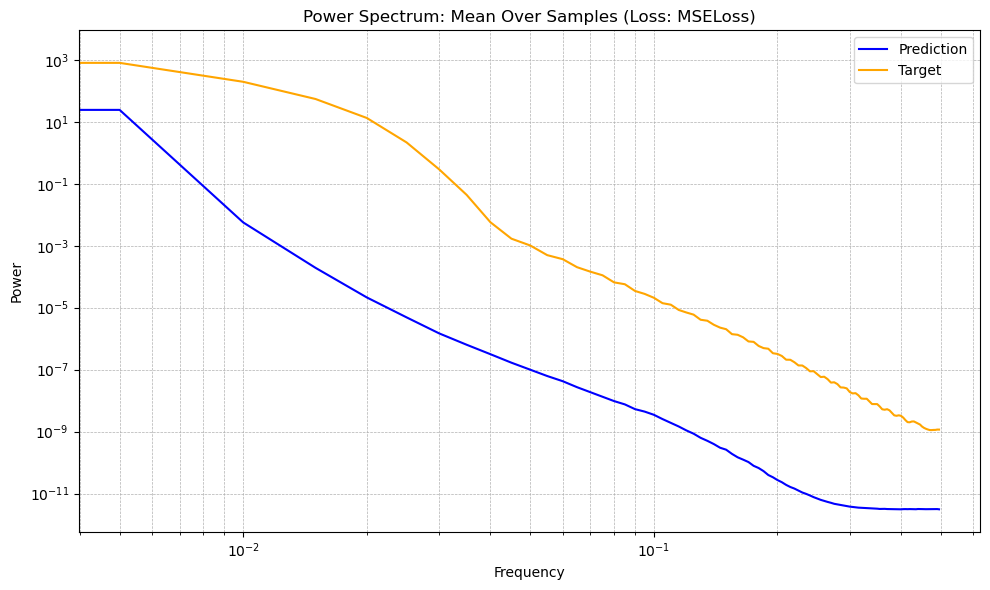

In [13]:
plot_mean_power_spectrum(sgs_pred, HF_test, loss_name="MSELoss", alpha_label="", figsize=(10, 6), show_slopes=False)

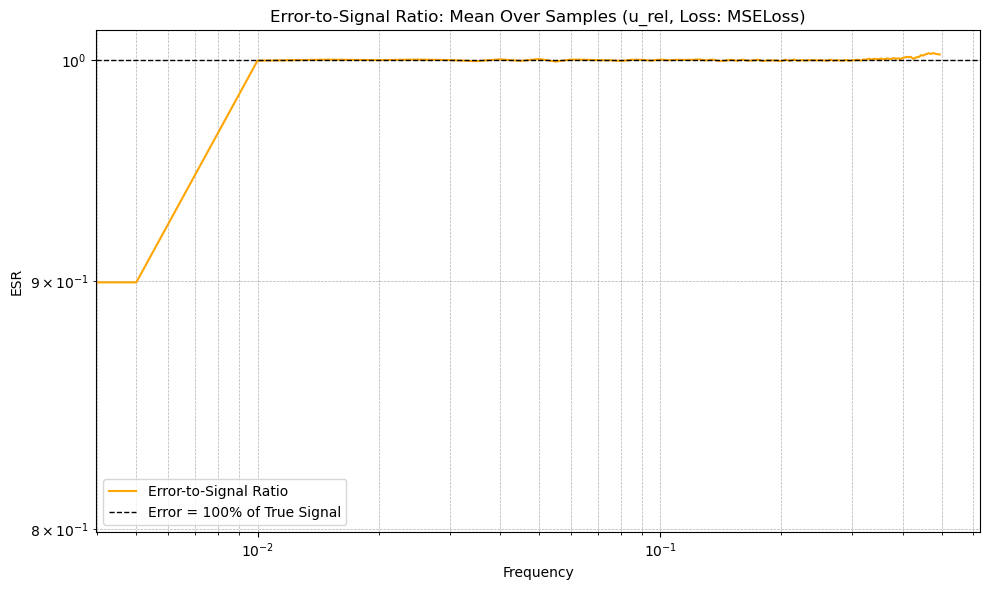

In [14]:
plot_mean_esr(sgs_pred, HF_test, loss_name="MSELoss", alpha_label="", figsize=(10, 6))

In [15]:
mse_val = mse(HF_test, sgs_pred)
r = pearson_corr(HF_test, sgs_pred)
r2 = r2_score(HF_test, sgs_pred)
k_thresh = first_esr_exceeds_half(sgs_pred, HF_test)
print(f"MSE is {mse_val}")
print(f"Pearson correlation coefficient is {r}")
print(f"r2 is {r2}")
print(f"ESR first exceeds half at {k_thresh}")

All frequencies have ESR > 1.0
MSE is 39.73229217529297
Pearson correlation coefficient is 0.10126064277215002
r2 is -0.05839800834655762
ESR first exceeds half at None


In [16]:
r2_noNorm = r2_per_sample(HF_test, sgs_pred)
r2_noNorm

array([-2.27542877e-01, -6.35504723e-04, -4.91914749e-02, -7.58159161e-03,
       -1.29854083e-01, -2.16951370e-02, -8.11599731e-01, -6.64745569e-02,
       -4.45993900e-01, -5.68675876e-01, -9.58329439e-02, -1.65814161e-02,
       -2.26637602e-01, -5.52666783e-01, -4.03301716e-02, -3.17565441e-01,
       -1.67430639e-02, -3.71737480e-02, -4.18934703e-01, -3.28940034e-01,
       -8.97219181e-02, -1.43907070e-02, -2.20820904e-02, -5.88877678e-01,
       -6.46059871e-01, -4.43682671e-02, -5.50534725e-02, -2.61504650e-02,
       -9.90271568e-04, -8.05778742e-01, -2.22873330e-01, -2.89646268e-01,
       -6.33280516e-01, -1.62265420e-01, -5.80735207e-02, -1.43512487e-02,
       -2.64854431e-02, -3.72650862e-01, -3.36909413e-01, -4.46629524e-02,
       -2.04909682e-01, -2.59952545e-02, -3.36641073e-02, -4.51533079e-01,
       -7.77000189e-02, -7.78620243e-02, -2.81159043e-01,  1.64105296e-02,
        2.06971169e-03, -3.91962528e-02, -1.26943827e-01, -1.01189303e+00,
       -1.54842138e-02, -

# Case 2: Normalization

In [17]:
reset_seeds(42)
model2 = FCNN(config=config)
model2

FCNN(
  (conv): Sequential(
    (0): Conv2d(6, 128, kernel_size=(5, 5), stride=(1, 1), padding=same, padding_mode=reflect)
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (7): ReLU()
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (10): ReLU()
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (13): ReLU()
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affi

In [18]:
var_LR = ['u_relative', 'v_relative', 't_ref', 'surface_temp', 'q_ref', 'slp']
train_loader, val_loader, test_loader, HF_test, LR_test = prepare_dataloaders_multiVar(ds_HF_reg, ds_LR_reg, var_LR=var_LR, var_HF='heatflux_diff', batch_size=32, normalization_type='normalization')

Training set size: 510
Validation set size: 109
Testing set size: 111


In [19]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)
device = torch.device("cuda")

In [20]:
train_losses, val_losses, r2_vals = train_model(model2, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_normalized_r2.pth',
            n_epochs=2000, patience=30, stop_crit='R2', lr_sched_crit='R2') # n_epochs=2000)

Trainable Parameters: 149569
Epoch 1, Train Loss: 4.998e-01, Val Loss: 4.702e-01, Val R²: -233.9636, Epoch Time: 13.23s
Model saved at epoch 1
Epoch 2, Train Loss: 3.902e-01, Val Loss: 3.027e-01, Val R²: -156.5340, Epoch Time: 13.49s
Model saved at epoch 2
Epoch 3, Train Loss: 2.743e-01, Val Loss: 1.497e-01, Val R²: -70.8828, Epoch Time: 12.98s
Model saved at epoch 3
Epoch 4, Train Loss: 1.071e-01, Val Loss: 2.241e-02, Val R²: -10.0311, Epoch Time: 12.81s
Model saved at epoch 4
Epoch 5, Train Loss: 1.828e-02, Val Loss: 1.652e-02, Val R²: -5.6409, Epoch Time: 12.83s
Model saved at epoch 5
Epoch 6, Train Loss: 9.985e-03, Val Loss: 6.396e-03, Val R²: -1.6259, Epoch Time: 12.92s
Model saved at epoch 6
Epoch 7, Train Loss: 4.346e-03, Val Loss: 3.003e-03, Val R²: -0.3315, Epoch Time: 12.95s
Model saved at epoch 7
Epoch 8, Train Loss: 3.480e-03, Val Loss: 2.918e-03, Val R²: -0.1958, Epoch Time: 13.14s
Model saved at epoch 8
Epoch 9, Train Loss: 3.179e-03, Val Loss: 3.113e-03, Val R²: -0.2430,

In [21]:
device = torch.device("cuda")
sgs_pred = evaluate_model_sr(model2, device, test_loader, HF_test, './model_normalized_r2.pth')
sgs_pred

Loaded model parameters from ./model_normalized_r2.pth


array([[[0.66766214, 0.6661324 , 0.6623938 , ..., 0.6605085 ,
         0.6624614 , 0.66717416],
        [0.71106195, 0.70998436, 0.7068178 , ..., 0.69279915,
         0.69339234, 0.6977211 ],
        [0.73851204, 0.73741245, 0.73399967, ..., 0.70907336,
         0.71009487, 0.7137537 ],
        ...,
        [0.69763935, 0.69656897, 0.696254  , ..., 0.748622  ,
         0.74941295, 0.7474967 ],
        [0.6938612 , 0.6926363 , 0.6922276 , ..., 0.7480151 ,
         0.74880576, 0.74689037],
        [0.68638587, 0.68525124, 0.68480104, ..., 0.745922  ,
         0.7467091 , 0.74479586]],

       [[0.70428115, 0.7047825 , 0.7037194 , ..., 0.689353  ,
         0.69064474, 0.6856575 ],
        [0.70928884, 0.70976967, 0.70867306, ..., 0.69264925,
         0.6939368 , 0.6889512 ],
        [0.71191   , 0.7123663 , 0.71123224, ..., 0.6929084 ,
         0.69419616, 0.68920666],
        ...,
        [0.7584034 , 0.7600368 , 0.7597722 , ..., 0.7214631 ,
         0.7212027 , 0.7213613 ],
        [0.7

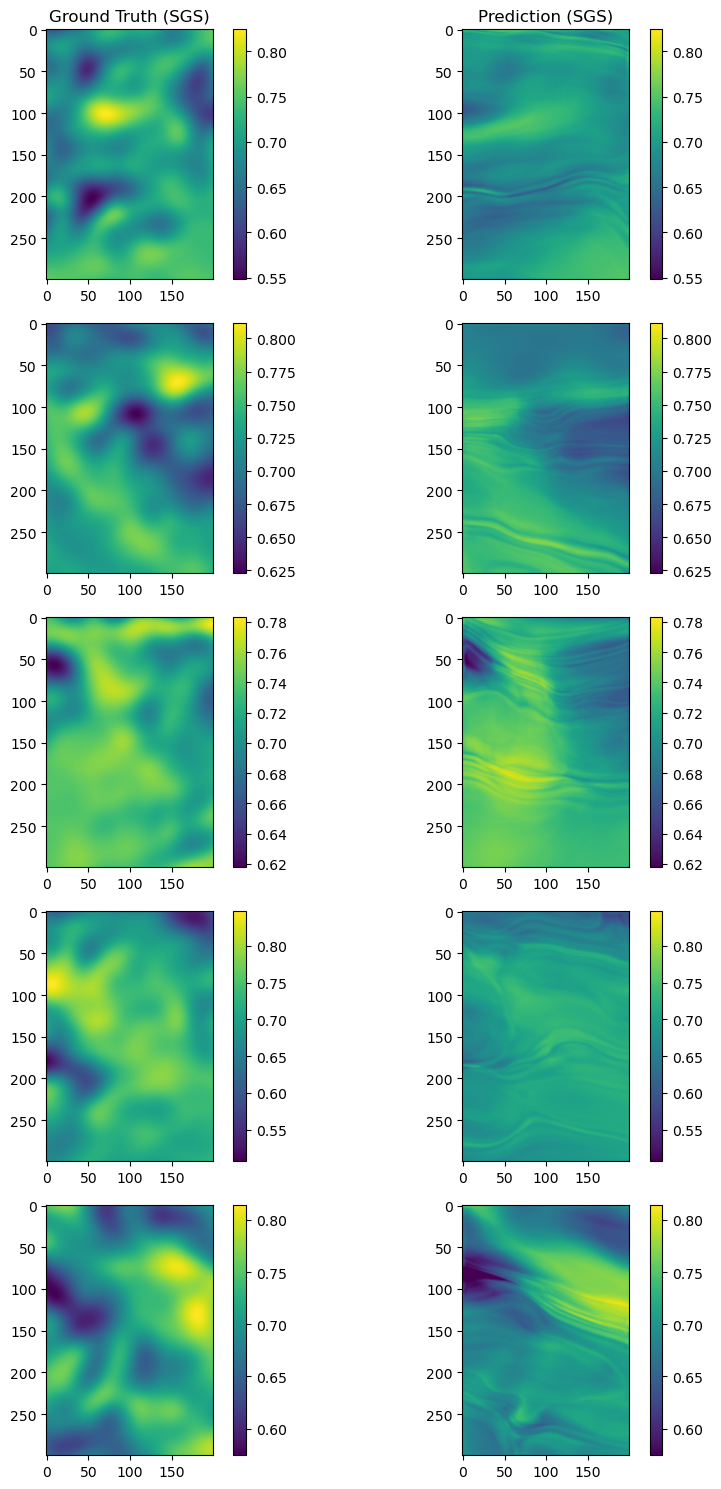

In [22]:
plot_predictions_vs_targets(HF_test, sgs_pred, num_samples=5, cmap='viridis', cbar_shared_lims=True)

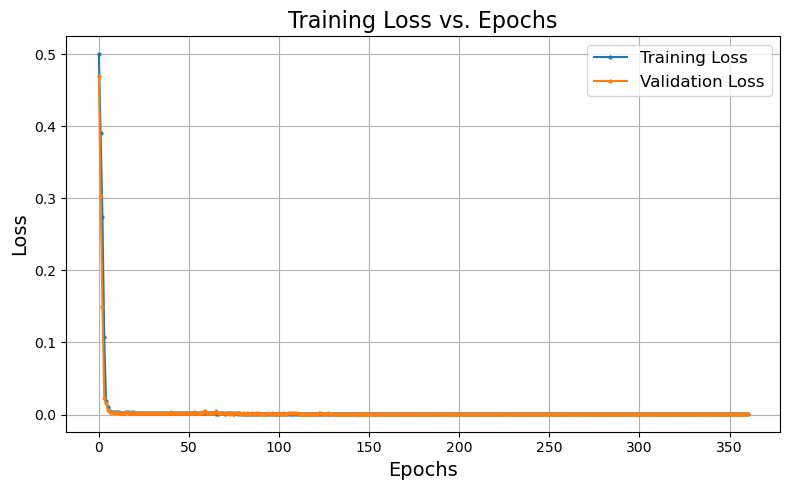

In [23]:
plot_train_val_losses(train_losses, val_losses)

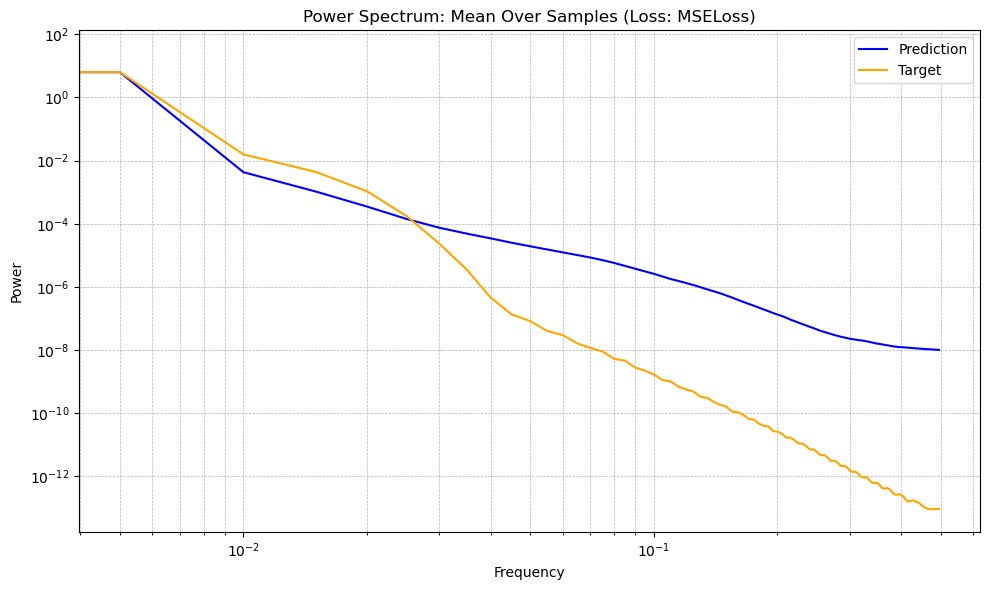

In [24]:
plot_mean_power_spectrum(sgs_pred, HF_test, loss_name="MSELoss", alpha_label="", figsize=(10, 6), show_slopes=False)

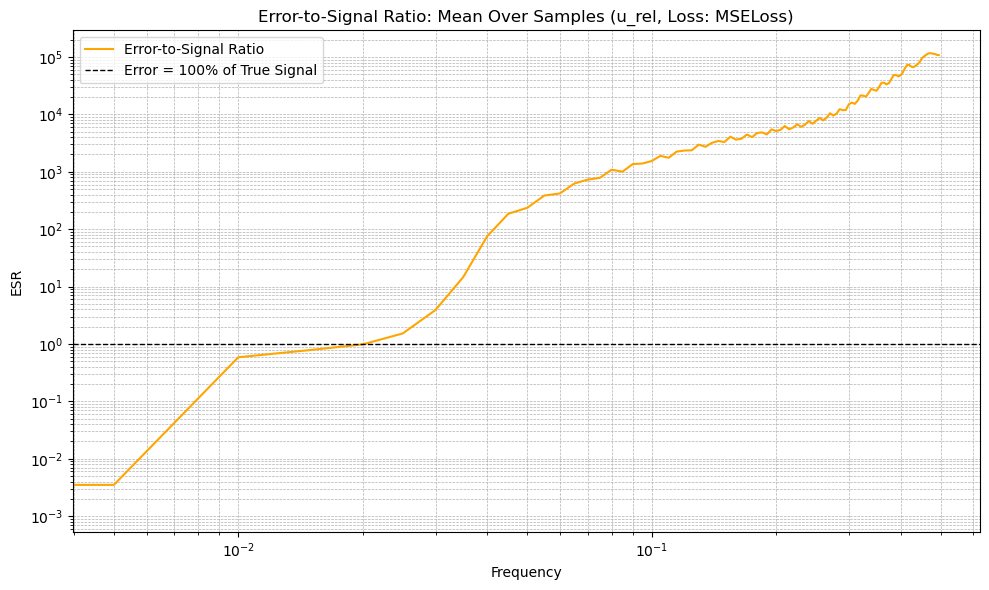

In [25]:
plot_mean_esr(sgs_pred, HF_test, loss_name="MSELoss", alpha_label="", figsize=(10, 6))

In [26]:
mse_val = mse(HF_test, sgs_pred)
r = pearson_corr(HF_test, sgs_pred)
r2 = r2_score(HF_test, sgs_pred)
k_thresh = first_esr_exceeds_half(sgs_pred, HF_test)
print(f"MSE is {mse_val}")
print(f"Pearson correlation coefficient is {r}")
print(f"r2 is {r2}")
print(f"ESR first exceeds half at {k_thresh}")

All frequencies have ESR > 1.0
MSE is 0.0013198961969465017
Pearson correlation coefficient is 0.7500921062152238
r2 is 0.5621162056922913
ESR first exceeds half at None


In [27]:
r2_norm = r2_per_sample(HF_test, sgs_pred)
r2_norm

array([ 2.56357133e-01,  5.07803679e-01,  3.06935787e-01,  3.04054677e-01,
        4.61610734e-01,  6.79739118e-01,  3.14520419e-01,  1.19712114e-01,
        5.86784005e-01,  1.80551827e-01,  6.72343314e-01,  5.07808447e-01,
        4.76025879e-01, -6.26307845e-01,  5.66694379e-01,  3.95740747e-01,
        5.55777311e-01,  7.95385003e-01,  1.19327188e-01,  7.09599495e-01,
        5.77763438e-01,  7.14642048e-01, -1.43652916e-01,  6.09270811e-01,
        1.18758917e-01,  3.88096690e-01,  6.07655525e-01,  4.29616868e-01,
        2.92881310e-01,  5.53544760e-01,  6.42528892e-01,  8.09030533e-02,
        1.67493582e-01,  4.90602255e-01,  5.87868512e-01,  4.48273301e-01,
        4.44738448e-01,  7.45326638e-01,  1.10077858e-03,  5.87653041e-01,
        3.33463907e-01,  3.75589848e-01,  5.82609415e-01,  6.61604583e-01,
        5.72506905e-01,  4.46992815e-01,  4.99314010e-01,  2.50292957e-01,
        4.18251634e-01,  3.74564767e-01,  5.21928668e-01,  4.96075153e-01,
        6.04517937e-01,  

# Case 3: Standardization

In [28]:
reset_seeds(42)
model3 = FCNN(config=config)
model3

FCNN(
  (conv): Sequential(
    (0): Conv2d(6, 128, kernel_size=(5, 5), stride=(1, 1), padding=same, padding_mode=reflect)
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (7): ReLU()
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (10): ReLU()
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (13): ReLU()
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affi

In [29]:
var_LR = ['u_relative', 'v_relative', 't_ref', 'surface_temp', 'q_ref', 'slp']
train_loader, val_loader, test_loader, HF_test, LR_test = prepare_dataloaders_multiVar(ds_HF_reg, ds_LR_reg, var_LR=var_LR, var_HF='heatflux_diff', batch_size=32, normalization_type='standardization')

Training set size: 510
Validation set size: 109
Testing set size: 111


In [29]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model3.parameters(), lr=1e-3)
device = torch.device("cuda")

train_losses, val_losses, r2_vals = train_model(model3, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model1.pth',
            n_epochs=2000, patience=30, stop_crit='R2', lr_sched_crit='R2') # n_epochs=2000)

Trainable Parameters: 149569
Epoch 1, Train Loss: 9.530e-01, Val Loss: 5.199e-01, Val R²: 0.3292, Epoch Time: 13.11s
Model saved at epoch 1
Epoch 2, Train Loss: 5.883e-01, Val Loss: 4.642e-01, Val R²: 0.4046, Epoch Time: 13.16s
Model saved at epoch 2
Epoch 3, Train Loss: 5.360e-01, Val Loss: 4.369e-01, Val R²: 0.4508, Epoch Time: 12.84s
Model saved at epoch 3
Epoch 4, Train Loss: 5.288e-01, Val Loss: 4.514e-01, Val R²: 0.4327, Epoch Time: 12.74s
Model saved at epoch 4
Epoch 5, Train Loss: 5.151e-01, Val Loss: 4.505e-01, Val R²: 0.4222, Epoch Time: 12.61s
Model saved at epoch 5
Epoch 6, Train Loss: 5.124e-01, Val Loss: 4.633e-01, Val R²: 0.4325, Epoch Time: 12.76s
Model saved at epoch 6
Epoch 7, Train Loss: 5.109e-01, Val Loss: 4.426e-01, Val R²: 0.4469, Epoch Time: 12.84s
Model saved at epoch 7
Epoch 8, Train Loss: 5.335e-01, Val Loss: 5.487e-01, Val R²: 0.3394, Epoch Time: 12.89s
Model saved at epoch 8
Epoch 9, Train Loss: 5.159e-01, Val Loss: 4.274e-01, Val R²: 0.4668, Epoch Time: 12

KeyboardInterrupt: 

In [30]:
device = torch.device("cuda")
sgs_pred = evaluate_model_sr(model3, device, test_loader, HF_test, './model1.pth')
sgs_pred

Loaded model parameters from ./model1.pth


array([[[ 2.4441528e-01,  4.3714532e-01,  2.6353565e-01, ...,
          6.9440597e-01,  7.0481145e-01,  6.8767059e-01],
        [-7.2129250e-01, -5.8962524e-01, -7.0739734e-01, ...,
          1.0008814e+00,  9.6463275e-01,  9.7112155e-01],
        [-7.3036891e-01, -6.7874885e-01, -7.2693807e-01, ...,
          1.2608501e+00,  1.2725544e+00,  1.3108081e+00],
        ...,
        [ 6.7777693e-01,  6.0527009e-01,  5.9357953e-01, ...,
          4.8916057e-01,  6.3976574e-01,  4.7602943e-01],
        [ 7.4821764e-01,  6.6587657e-01,  6.4622289e-01, ...,
          4.0707725e-01,  5.4820120e-01,  3.9087057e-01],
        [ 9.5444834e-01,  8.4637278e-01,  8.2244271e-01, ...,
          4.1273096e-01,  5.5699831e-01,  3.9762825e-01]],

       [[ 1.2248592e-02, -8.1584431e-02, -3.0811230e-02, ...,
         -1.7606416e-01, -9.9879682e-02, -1.5776703e-01],
        [-1.5070173e-01, -2.4194933e-01, -1.9253682e-01, ...,
         -2.9945180e-01, -2.2784419e-01, -2.7872884e-01],
        [-6.1041135e-02, 

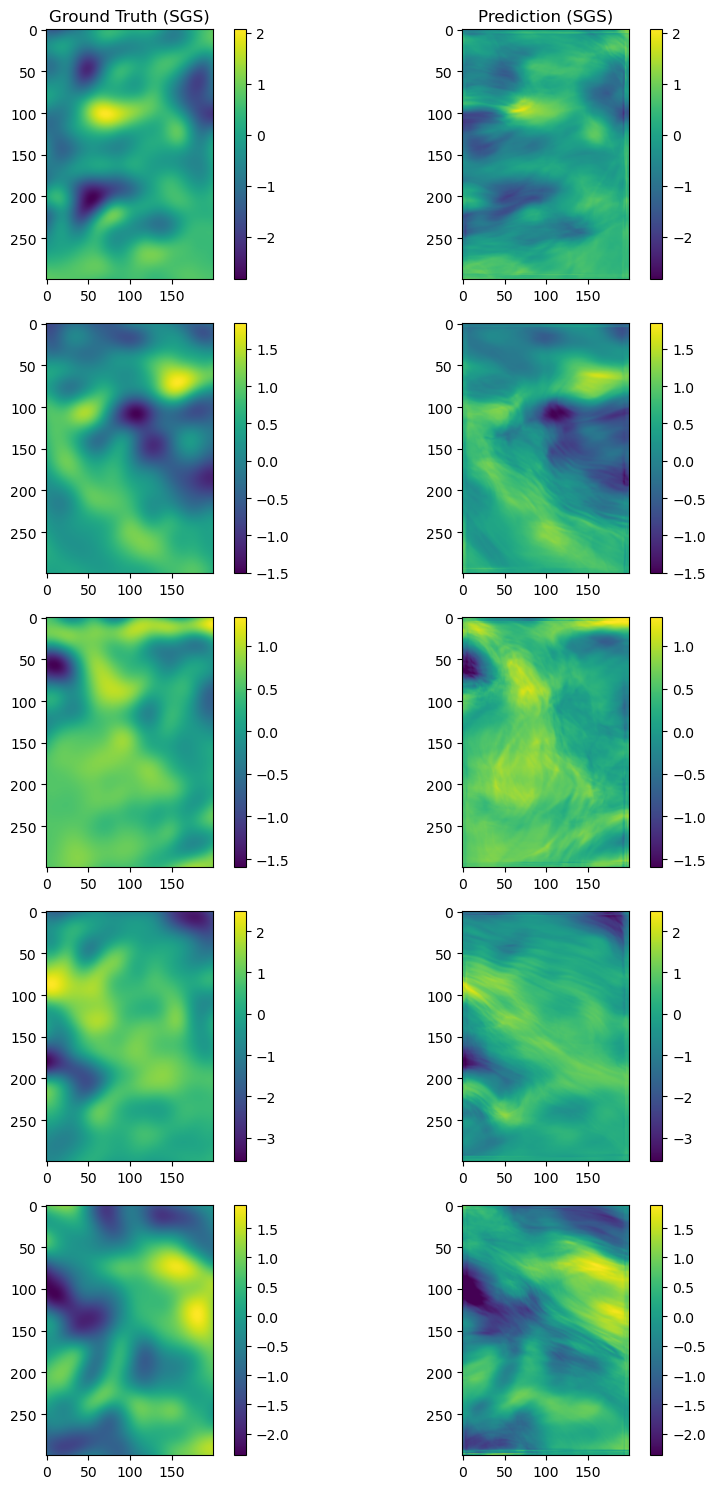

In [31]:
plot_predictions_vs_targets(HF_test, sgs_pred, num_samples=5, cmap='viridis', cbar_shared_lims=True)

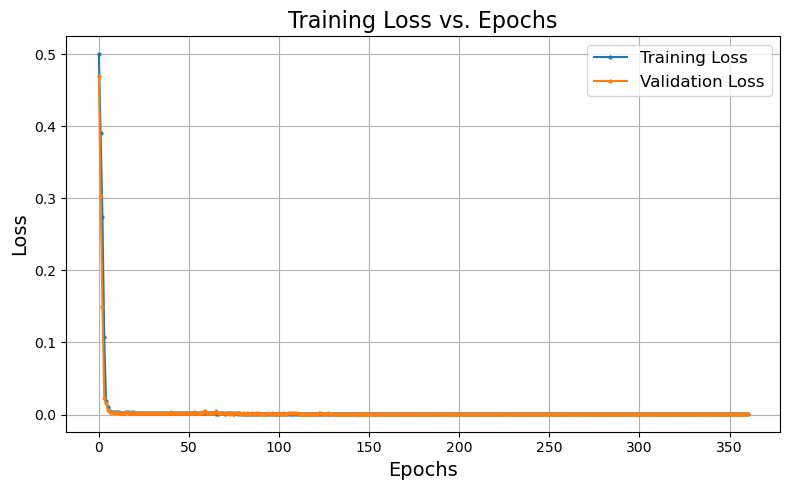

In [32]:
plot_train_val_losses(train_losses, val_losses)

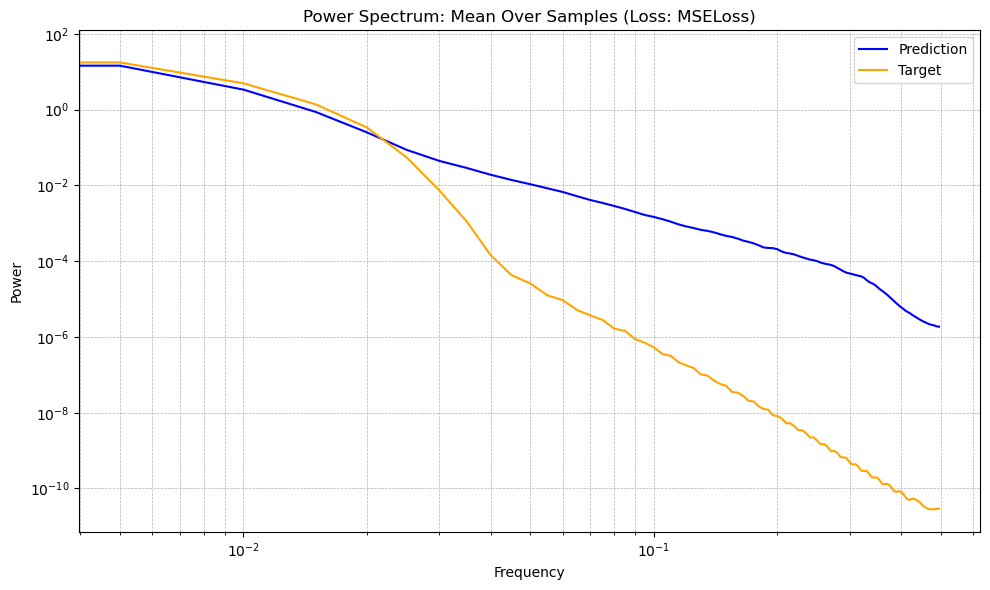

In [33]:
plot_mean_power_spectrum(sgs_pred, HF_test, loss_name="MSELoss", alpha_label="", figsize=(10, 6), show_slopes=False)

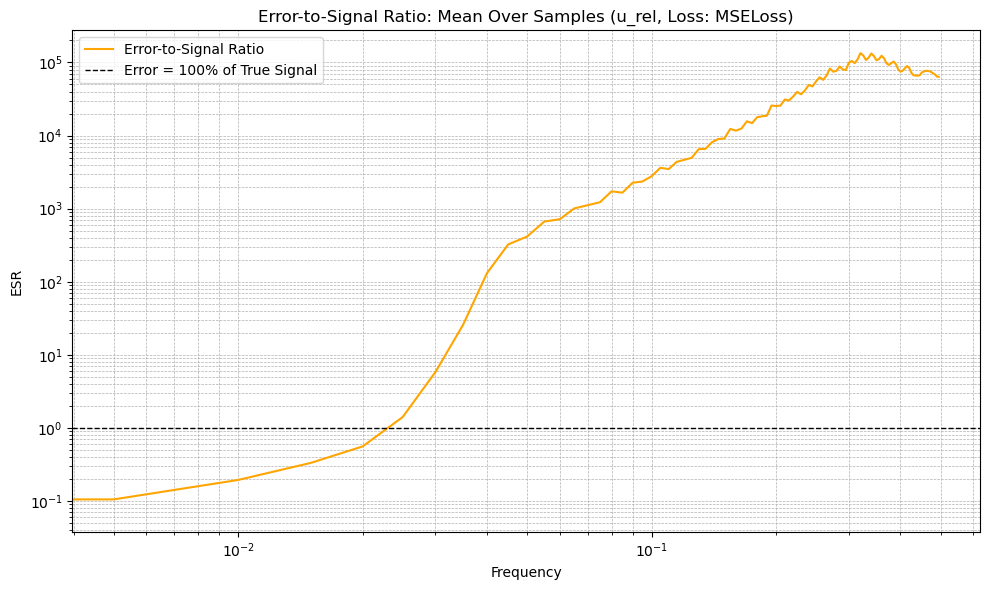

In [34]:
plot_mean_esr(sgs_pred, HF_test, loss_name="MSELoss", alpha_label="", figsize=(10, 6))

In [35]:
mse_val = mse(HF_test, sgs_pred)
r = pearson_corr(HF_test, sgs_pred)
r2 = r2_score(HF_test, sgs_pred)
k_thresh = first_esr_exceeds_half(sgs_pred, HF_test)
print(f"MSE is {mse_val}")
print(f"Pearson correlation coefficient is {r}")
print(f"r2 is {r2}")
print(f"ESR first exceeds half at {k_thresh}")

All frequencies have ESR > 1.0
MSE is 0.13092097640037537
Pearson correlation coefficient is 0.9286974791444391
r2 is 0.8620995283126831
ESR first exceeds half at None


In [ ]:
r2_stand = r2_per_sample(HF_test, sgs_pred)
r2_stand

array([0.70436668, 0.88604653, 0.7856223 , 0.82140255, 0.87581384,
       0.79562861, 0.77053869, 0.80609798, 0.86055964, 0.77115005,
       0.9024148 , 0.7739259 , 0.89295101, 0.56946594, 0.86314809,
       0.7547456 , 0.88276452, 0.88083565, 0.73056036, 0.91649097,
       0.82086951, 0.86747336, 0.47761369, 0.8606829 , 0.78232992,
       0.82245845, 0.80251592, 0.84611028, 0.58425194, 0.86076075,
       0.84787464, 0.6670624 , 0.65002447, 0.75795203, 0.29631442,
       0.89109021, 0.87136728, 0.93056679, 0.79596567, 0.82471812,
       0.86633384, 0.76546204, 0.85439962, 0.95283937, 0.88624555,
       0.82835627, 0.88825607, 0.7725426 , 0.82901096, 0.8371141 ,
       0.87758952, 0.7726261 , 0.85731244, 0.77751917, 0.85873574,
       0.5781157 , 0.79790235, 0.83454114, 0.91288191, 0.75022089,
       0.83278823, 0.84637934, 0.83442634, 0.88480461, 0.81732333,
       0.87693578, 0.9304893 , 0.89751184, 0.79480904, 0.78234524,
       0.85963941, 0.88768882, 0.77228403, 0.90141916, 0.88022

# Figure Generation

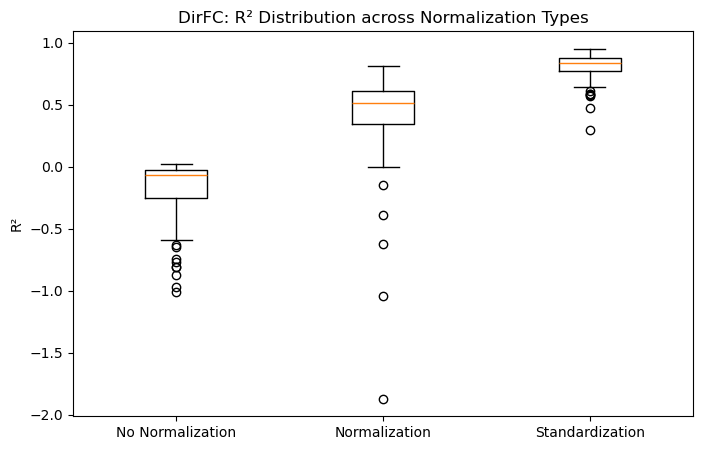

In [ ]:
data = [r2_noNorm, r2_norm, r2_stand]

plt.figure(figsize=(8, 5))
plt.boxplot(data, vert=True)  # each array becomes a separate boxplot
plt.xticks([1, 2, 3], ["No Normalization", "Normalization", "Standardization"])  # label each box
plt.ylabel("R²")
plt.title("DirFC: R² Distribution across Normalization Types")
plt.show()

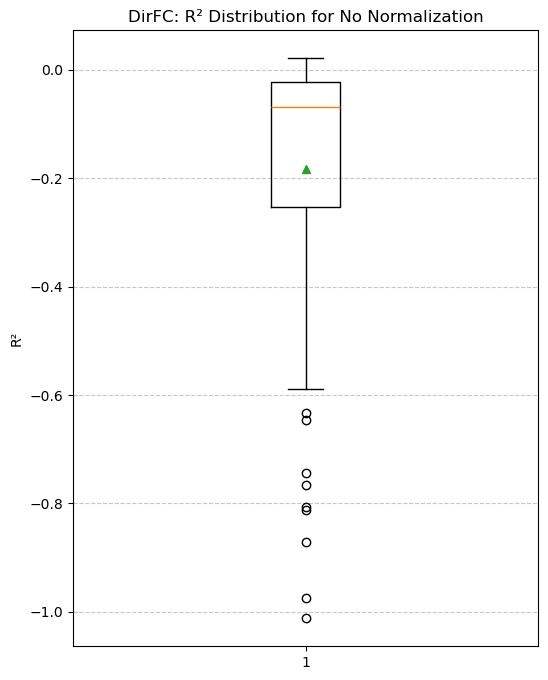

In [ ]:
plt.figure(figsize=(6, 8))
plt.boxplot(r2_noNorm, vert=True, showmeans=True)
plt.ylabel("R²")
plt.title("DirFC: R² Distribution for No Normalization")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

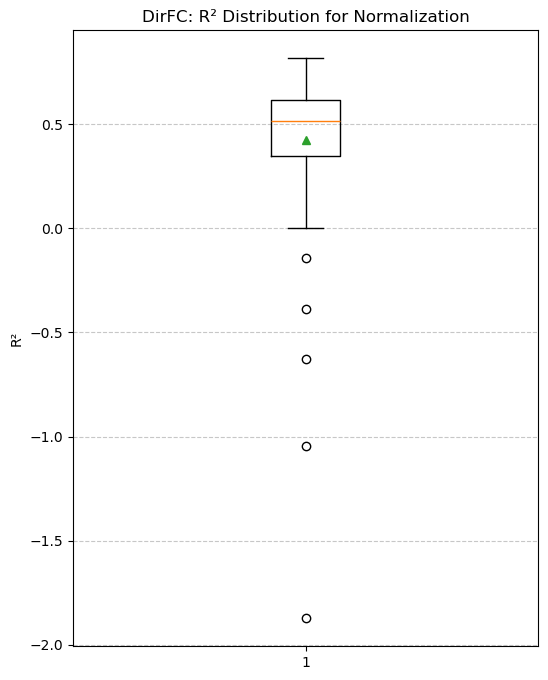

In [ ]:
plt.figure(figsize=(6, 8))
plt.boxplot(r2_norm, vert=True, showmeans=True)
plt.ylabel("R²")
plt.title("DirFC: R² Distribution for Normalization")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

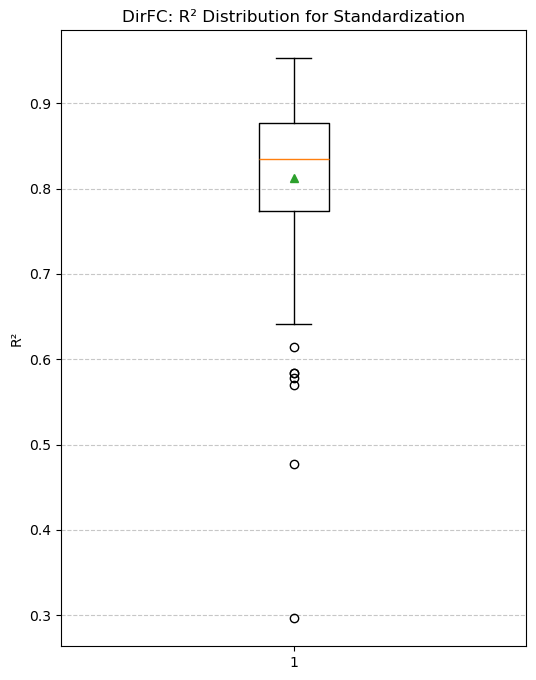

In [ ]:
plt.figure(figsize=(6, 8))
plt.boxplot(r2_stand, vert=True, showmeans=True)
plt.ylabel("R²")
plt.title("DirFC: R² Distribution for Standardization")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()